In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tic_env import TictactoeEnv, OptimalPlayer

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque 
from random import random, sample, randint

In [28]:
def valid_move(grid, move):
    return grid[(move//3,move%3)] == 0

def act(model, grid, epsilon):
    return act_random(grid) if random()<epsilon else act_optimal(model,grid)

def act_random(grid):
    actions = [i for i in range(9) if valid_move(grid,i)]
    return actions[randint(0,len(actions)-1)]

def act_optimal(model, grid):
     with torch.no_grad():
            actions_reward = model(grid_to_state(grid))
            return torch.argmax(actions_reward).item()

        
def push(memory, last_state, last_move, grid, reward):
    if last_move is not None and last_state is not None:
        memory.push(last_state, last_move, grid, reward)
    

def grid_to_state(grid):
    return torch.tensor(np.stack([grid>0,grid<0])).float().view(1,-1)

def network():
    return nn.Sequential(nn.Linear(9*2,128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128,128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128,9))

#######from pytroch tutorial
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

In [29]:
def train_deep_q(epsilon=0.1, optimal_epsilon=0.5, buffer_size=10000, batch_size=64, nb_games = 20000, update_length = 500, average_length = 250.0):
    Turns = np.array(['X','O'])
    
    policy_net = network()
    target_net = network()
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    
    memory = ReplayMemory(buffer_size)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
    criterion = nn.HuberLoss()
    
    optimal = OptimalPlayer(epsilon=0.5, player=Turns[0])

    optimize_m = lambda  : optimize_model(policy_net, target_net, memory ,  optimizer, criterion, batch_size = batch_size, gamma=0.99)
    
    average_loss = []
    average_reward = []
 
    
    rewards = 0
    loss = 0
  
    for i in tqdm(range(nb_games)):
        optimal.player = Turns[np.mod(i,2)]
        
        (mean_loss, reward_) = train_on_a_game(optimal, policy_net, epsilon, Turns[np.mod(i+1,2)], optimize_m, memory)
        
        loss += mean_loss
        rewards += reward_
        
        
        if np.mod(i+1,update_length) == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if np.mod(i+1,average_length) == 0:
            average_loss.append(loss/average_length)
            average_reward.append(rewards/average_length)
            loss = 0
            rewards = 0
           
    return average_loss, average_reward


def train_on_a_game(optimal, model, epsilon, model_turn, optimize_model, memory):
    env = TictactoeEnv()
    grid, _, __ = env.observe()
    
    sum_loss= 0
    nb_updates = 0
    
    last_move = None
    last_state = None
    
    for j in range(9):
            
            if env.current_player == model_turn:
                move =  act(model, grid, epsilon)
               
                push(memory, last_state, last_move, grid, 0)
                last_move = move
                last_state = grid
                    
            else:
                move = optimal.act(grid)
                move = move[0]*3+move[1]
                
          
            sum_loss += optimize_model()
            nb_updates += 1
            
            
            
            if not valid_move(grid,move):
                push(memory, last_state, last_move, None, -1)
                return sum_loss/max(1,nb_updates), -1
            
                
            grid, end, winner = env.step(move, print_grid=False)
            
 
            
            if end:
                reward = env.reward(player=model_turn)
                push(memory, last_state, last_move, None, reward)
                return sum_loss/max(1,nb_updates), reward
                

def optimize_model(policy_net, target_net, memory , optim, criterion, batch_size, gamma=0.99):
    ##### inspired from :: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    if len(memory)<batch_size:
        return 0
    
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
  
   
    
    state_batch = torch.cat(list(map(lambda x : grid_to_state(x), batch.state)))
    action_batch = torch.tensor(batch.action).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward).unsqueeze(1)

 

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    with torch.no_grad():
        next_state_values = torch.zeros(batch_size)
        
        non_none_states = [grid_to_state(s) for s in batch.next_state if s is not None]
        if len(non_none_states)>0:
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool) 
            non_final_next_states = torch.cat(non_none_states) 
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
            
        next_state_values = next_state_values.view((-1,1))
      
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch


    # Compute Huber loss

    loss = criterion(state_action_values, expected_state_action_values)
    
    # Optimize the model
    optim.zero_grad()
    loss.backward()
   
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optim.step()
   
   
    return loss.item()
    

In [30]:
average_loss, average_reward = train_deep_q(nb_games=500)

100%|█████████████████████████████████████████| 500/500 [00:37<00:00, 13.17it/s]


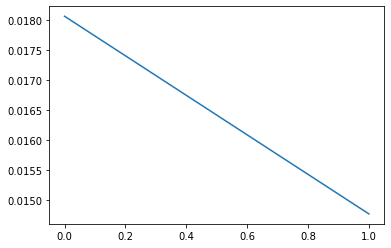

In [31]:
plt.plot(average_loss)

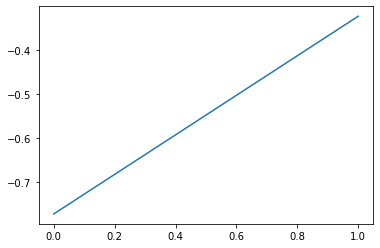

In [32]:
plt.plot(average_reward)